# Buckling analysis of a column
This notebook shows the calculation of the buckling load for a pin-ended column loaded in compression. Four methods are considered: Euler's analytical formula, linear buckling analysis with MSC Nastran SOL 105, nonlinear buckling analysis with MSC Nastran SOL 106, calculation of the eigenvalues of the tangent stiffness matrix (using MSC Nastran SOL 106). The notebook is freely inspired by [this article](https://simcompanion.hexagon.com/customers/s/article/buckling-analysis-of-column-kb8021539) on the buckling analysis of a column with MSC Nastran.
* [Euler's buckling load](#euler)
* [Numerical model](#numerical-model)
* [Linear buckling analysis (SOL 105)](#linear-buckling)
* [Nonlinear buckling analysis (SOL 106)](#nonlinear-buckling)
* [Eigenvalues of tangent stiffness matrix (SOL 106)](#tangent-stiffness-matrix)

## Euler's buckling load <a name="euler"></a>
Let's consider a column with diameter $d=20$ mm and length $l=420$ mm. The Young's modulus is $E=207000$ MPa. The column is pinned at one end and has a roller support at the other end, where the load is applied in compression.

Euler's buckling load $P_{cr}$ is given by:
$$P_{cr}=\frac{\pi^2EI}{l^2},$$
where the area moment of inertia $I$ for a circular cross-sectional shape is calculated as:
$$I = \frac{\pi d^4}{64}.$$

In [113]:
import numpy as np
d = 20  # [mm]
l = 420  # [mm]
E = 207000.  # [MPa]
I = np.pi*d**4/64  # [mm^4]
P_cr = np.pi**2*E*I/l**2  # [N]
print(f'Euler\'s buckling load: {P_cr:.0f} N')

Euler's buckling load: 90962 N


## Numerical model <a name="numerical-model"></a>
We need to create a numerical model of the column for the analyses with MSC Nastran. The `pyNastran` package is used to create a base model, which will be later copied and completed depending on the analysis that we want to run. For the material properties, we need to define the Poisson's ratio $\nu$ and the density $\rho$ of the material, beyond the Young's modulus previously defined. The shear modulus $G$ will be calculated according to the following equation:
$$E=2(1+\nu)G.$$
Our column has constant cross-sectional properties, so we don't need to define anything else beyond the diameter and the length. We discretize the column into 420 beam elements. We consider a two-dimensional problem in the $xy$ plane, so permanent single-point constraints for all nodes are enforced for the appropriate degrees of freedom. For the boundary conditions we define two single-point constraints: a pin support at one end of the column and a roller support at the other end.

With the mentioned input variables we call the `create_column_base_model` function, which returns a `BDF` object with our base model. Finally, we define the name of our model.


In [114]:
import column_buckling_utils
nu = 0.3
rho = 7.8e-4  # [tons/mm^3]
no_elements = 420
base_model = column_buckling_utils.create_column_base_model(E, nu, rho, d, l, no_elements)
base_model_name = 'column'

subcase=0 already exists...skipping


Let's visualize some information about the model that we have just created.

In [115]:
print(base_model.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcadds[3]
  SPCADD:  1

bdf.spcs[1]
  SPC1:    1

bdf.spcs[2]
  SPC1:    1

bdf.params
  PARAM    : 2

bdf.nodes
  GRID     : 421

bdf.elements
  CBEAM    : 420

bdf.properties
  PBEAML   : 1

bdf.materials
  MAT1     : 1




## Linear buckling analysis (SOL 105) <a name="linear-buckling"></a>
We start by copying our base model into a new variable. Then we specify the solution sequence, the title of our analysis and the name of the model.

In [116]:
linear_buckling_model = base_model.__deepcopy__({})
linear_buckling_model.sol = 105
linear_buckling_model.case_control_deck.subcases[0].add('TITLE', 'Linear buckling analysis of a column', [], 'STRING-type')
linear_buckling_model_name = base_model_name + '_linear_buckling'

For the linear buckling analysis we need to define two subcases: one to apply the load in compression and the other to calculate the buckling eigenvalues. In the first subcase we apply a compression force to the roller-supported end of the column. We add a `FORCE` card to define the force magnitude, direction and its application point; then we add a `LOAD` card to define the corresponding load set.

In [117]:
force_sid = list(base_model.spcadds.keys())[0]+1
load_sid = force_sid+1
force_magnitude = P_cr
force_direction = [-1., 0., 0.]
linear_buckling_model.add_force(sid=force_sid, node=no_elements+1, mag=force_magnitude, xyz=force_direction)
linear_buckling_model.add_load(load_sid, scale=1., scale_factors=[1.], load_ids=[force_sid])

LOAD           5      1.      1.       4

Now we proceed with the creation of the first subcase.

In [118]:
import utils
load_application_subcase_id = 1
utils.create_static_load_subcase(linear_buckling_model, subcase_id=load_application_subcase_id, subtitle='Application of compression load', load_sid=load_sid)

For the second subcase we need to define the parameters to perform real eigenvalue analysis with the Lanczos method. We do that using the `EIGRL` card, specifying the calculation of only the first positive root.

In [119]:
eigrl_sid = load_sid+1
linear_buckling_model.add_eigrl(eigrl_sid, 0., nd=1)

EIGRL          6      0.               1

At this point we can create the second subcase and assign the id of the `EIGRL` card to the subcase.

In [120]:
eigenvalue_calculation_subcase_id = 2
linear_buckling_model.create_subcases(eigenvalue_calculation_subcase_id)
linear_buckling_model.case_control_deck.subcases[eigenvalue_calculation_subcase_id].add('SUBTITLE', 'Calculation of buckling eigenvalues', [], 'STRING-type')
linear_buckling_model.case_control_deck.subcases[eigenvalue_calculation_subcase_id].add_integer_type('METHOD', eigrl_sid)

The model for the linear buckling analysis is ready to run now! Let's call the `run_analysis` function that creates an appropriate directory, writes our `BDF` object `linear_buckling_model` to a bdf file and runs the analysis with Nastran.

In [121]:
import os
# Define name of analysis directory
analysis_directory_name = 'LinearBuckling'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
utils.run_analysis(analysis_directory_path, linear_buckling_model, linear_buckling_model_name, run_flag=True)

Finally, we read the op2 file and we calculate the predicted buckling load multiplying the load applied in the first subcase by the eigenvalue calculated in the second subcase.

In [122]:
from pyNastran.op2.op2 import read_op2
op2_filename = os.path.join(analysis_directory_path, linear_buckling_model_name + '.op2')
op2 = read_op2(op2_filename, debug=False)
sol_105_buckling_load = P_cr*op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'SOL 105 buckling load: {sol_105_buckling_load:.0f} N')
print(f'Difference with respect to analytical buckling load: {(1-sol_105_buckling_load/P_cr)*100:.2f} %')

SOL 105 buckling load: 90578 N
Difference with respect to analytical buckling load: 0.42 %


Let's visualize the result in terms of the buckling shape.

debug True
format ['nastran']
geomscript None
groups False
input ['C:\\Users\\qa21944\\Git\\phd-jupyter-notebooks\\ColumnBuckling\\TangentStiffnessMatrix\\column_tangent_stiffness_matrix.bdf']
is_groups False
log None
noupdate False
output ['C:\\Users\\qa21944\\Git\\phd-jupyter-notebooks\\ColumnBuckling\\LinearBuckling\\column_linear_buckling.op2']
plugin False
postscript take_picture.py
qt None
test False
user_geom None
user_points None
qt_version = 'pyqt5'
supported_formats = ['nastran', 'nastran', 'abaqus', 'avus', 'bedge', 'surf', 'ugrid', 'ugrid3d', 'cart3d', 'degen_geom', 'fast', 'lawgs', 'obj', 'openfoam_hex', 'openfoam_shell', 'openfoam_faces', 'panair', 'shabp', 'stl', 'su2', 'tecplot', 'tetgen', 'usm3d', 'avl', 'vrml']
load_batch_inputs {'format': ['nastran'], 'geomscript': None, 'groups': False, 'input': ['C:\\Users\\qa21944\\Git\\phd-jupyter-notebooks\\ColumnBuckling\\TangentStiffnessMatrix\\column_tangent_stiffness_matrix.bdf'], 'log': None, 'noupdate': False, 'output': ['

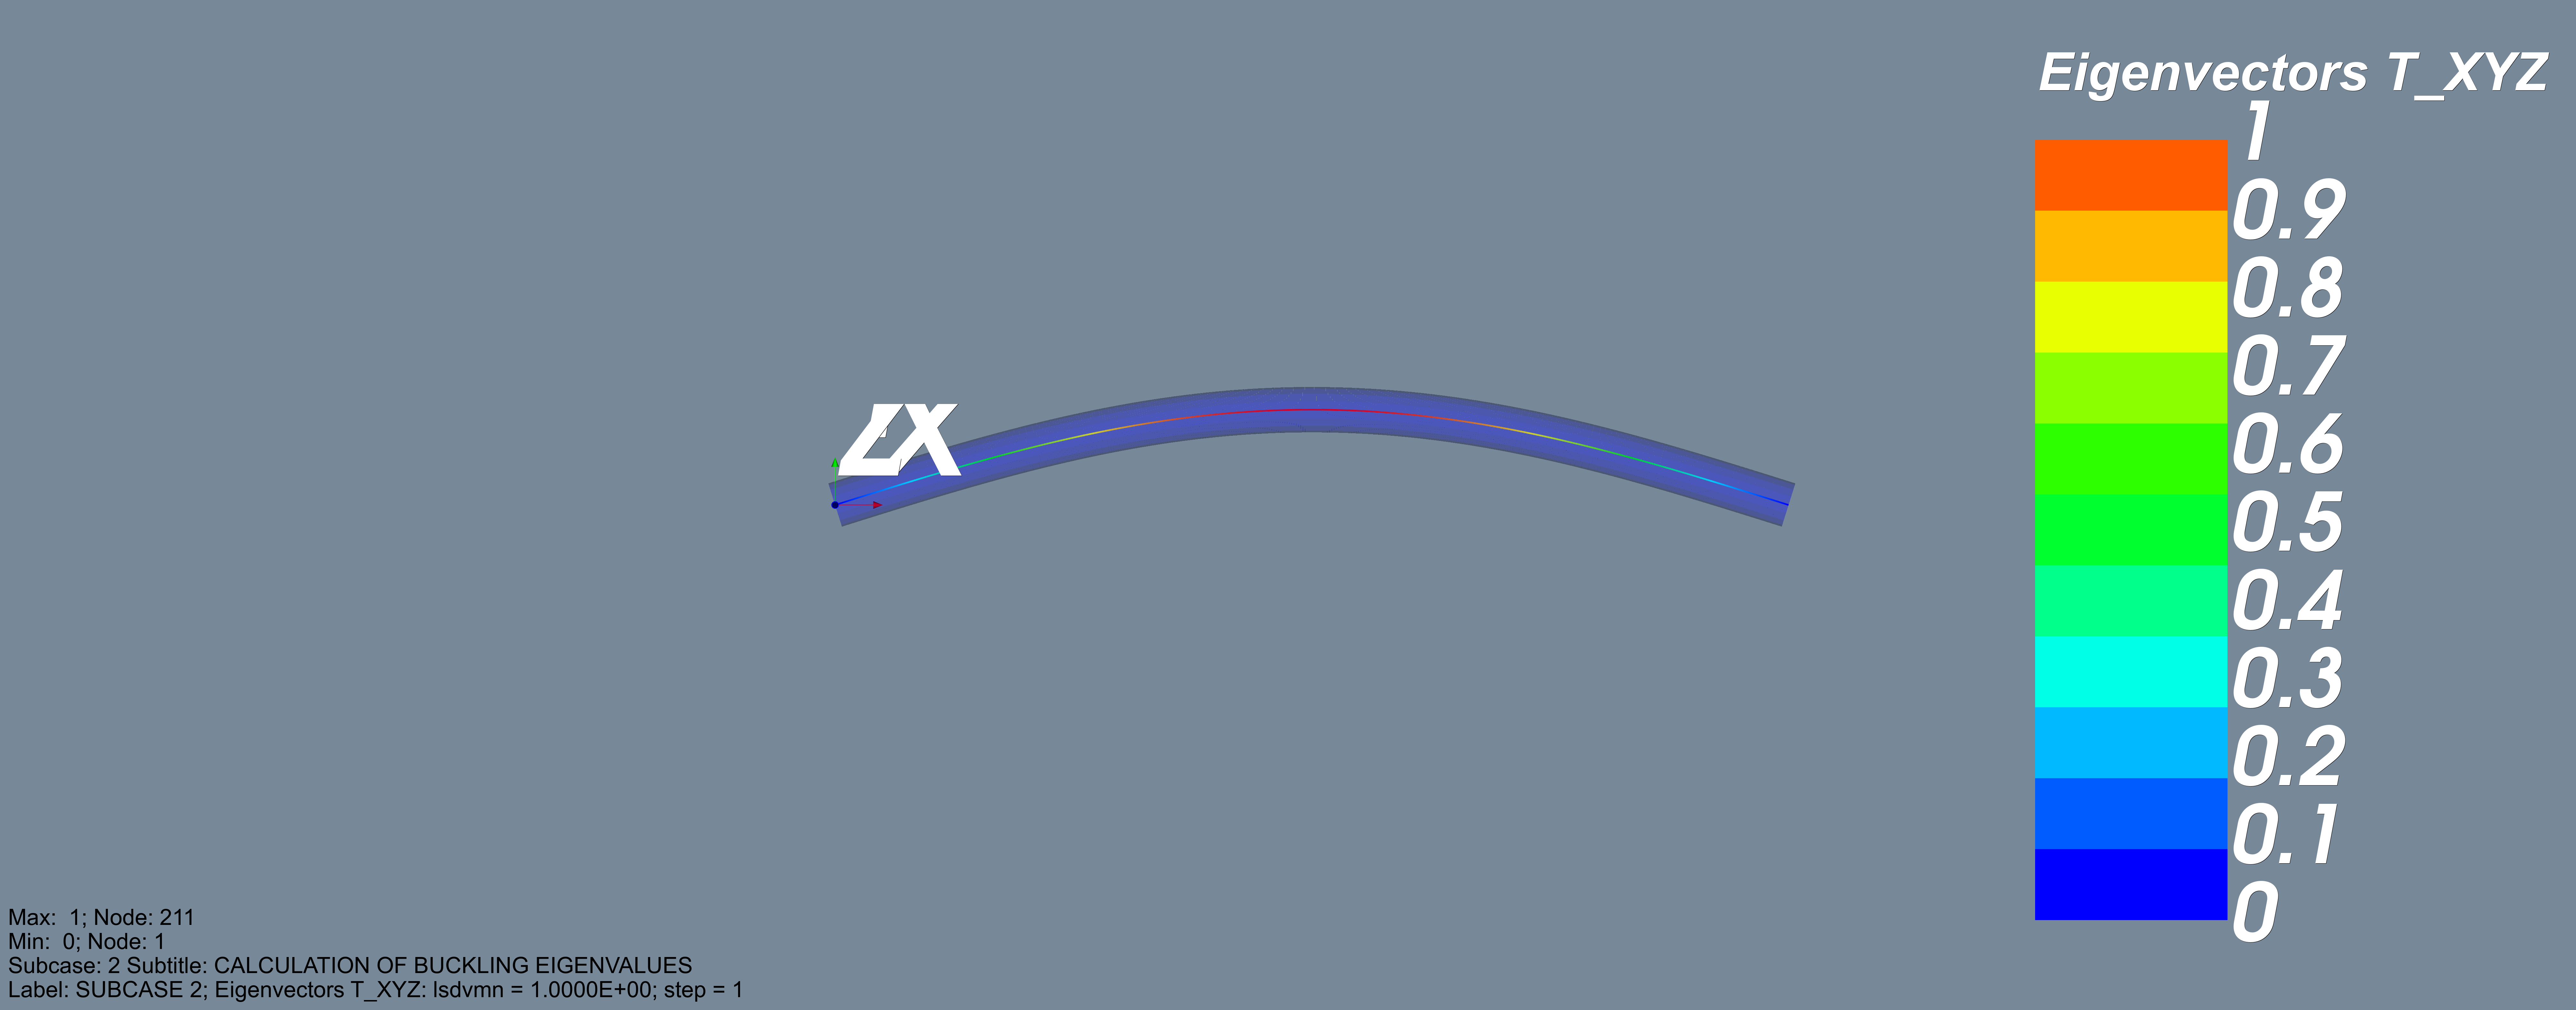

In [123]:
!pyNastranGUI {bdf_filename} {op2_filename} --postscript take_picture.py
from IPython.display import Image
Image(filename='column_sol105.png')

## Nonlinear buckling analysis (SOL 106) <a name="nonlinear-buckling"></a>
We copy our base model into a new variable and we specify the solution sequence, the title of the analysis and the name of the model as we did for the linear buckling analysis.

In [124]:
nonlinear_buckling_model = base_model.__deepcopy__({})
nonlinear_buckling_model.sol = 106
nonlinear_buckling_model.case_control_deck.subcases[0].add('TITLE', 'Nonlinear buckling analysis of a column', [], 'STRING-type')
nonlinear_buckling_model_name = base_model_name + '_nonlinear_buckling'

For the nonlinear analysis we need to specify some additional cards. At first we define the set of parameters for the nonlinear iteration strategy with the `NLPARM` card. We use the following settings.
* `ninc=100` to set the number of load increments
* `kmethod='ITER'` and `kstep=1` to update the stiffness matrix at every iteration
* `max_iter=25` to set the maximum number of iterations for each load increment
* `conv='PV'` to select convergence criteria based on load equilibrium error with vector component method
* `int_out='YES'` to process the output for every computed load increment
* `eps_p=1e-3` to set the error tolerance for the load criteria
* `max_bisect=10` to set the maximum number of bisections allowed for each load increment

We also add a `NLPCI` card to use the arc-length incremental solution strategy, defining the following parameters.
* `Type='CRIS'` to set Crisfield constraint type.
* `minalr=.01` and `maxalr=1.1` to set the minimum and maximum allowable arc-length adjustment ratio between increments, $MINALR \leq\frac{\Delta l_{new}}{\Delta l_{old}}\leq MAXALR$. Smaller values of $MAXALR$ were tested, but the analysis appeared to get stuck during subcase 4 around the bifurcation point.
* `desiter=5` to set the desired number of iterations for convergence, which is used for the arc-length adjustment: $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$ (where $I_{max}$ represents the number of iterations required for convergence in the previous load increment).
* `mxinc=2000` to set the maximum number of controlled increment steps allowed within a subcase.

In [125]:
nlparm_id = 1
nonlinear_buckling_model.add_nlparm(nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PV', int_out='YES', eps_p=1e-3, max_bisect=10)
nonlinear_buckling_model.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)
nonlinear_buckling_model.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.1, desiter=5, mxinc=2000)

NLPCI          1    CRIS     .01     1.1      0.               5    2000

We also need to define some additional parameters:
* `PARAM,BUCKLE,2` to request a nonlinear buckling analysis
* `PARAM,LGDISP,1` to assume all nonlinear structural element types that have a large displacement capability to have large displacement effects

In [126]:
nonlinear_buckling_model.add_param('BUCKLE', [2])
nonlinear_buckling_model.add_param('LGDISP', [1])

PARAM     LGDISP       1

For the nonlinear buckling analysis we can define only one subcase. SOL 106 calculates the nonlinear buckling load as it follows:
$$P_{cr}=P_n+\alpha\Delta P,$$
where $P_n$ is the applied load, $\alpha$ is the buckling factor calculated by SOL 106 and $\Delta P$ is the last load increment applied in the nonlinear analysis.

Let's define our first and only subcase, where we apply the buckling load found by the linear analysis of the previous section.

In [127]:
force_sid = list(base_model.spcadds.keys())[0]+1
load_sid = force_sid+1
force_magnitude = sol_105_buckling_load
nonlinear_buckling_model.add_force(sid=force_sid, node=no_elements+1, mag=force_magnitude, xyz=force_direction)
nonlinear_buckling_model.add_load(load_sid, scale=1., scale_factors=[1.], load_ids=[force_sid])
first_subcase_id = 1
utils.create_static_load_subcase(nonlinear_buckling_model, subcase_id=first_subcase_id, subtitle='Application of compression load', load_sid=load_sid)

Then we define the data needed to perform the buckling analysis using the `EIGB` card. The id of this card is then assigned to the subcase to set the real eigenvalue extraction parameters.

In [128]:
eigb_sid = load_sid+1
nonlinear_buckling_model.add_eigb(eigb_sid, method='INV', L1=-1e-10, L2=1e10, nep=1, ndp='', ndn='', norm='', G='', C='',)
nonlinear_buckling_model.case_control_deck.subcases[first_subcase_id].add_integer_type('METHOD', eigb_sid)

Analogously to the linear analysis, we create an appropriate directory where we can run the analysis, write our bdf file and run the analysis with Nastran.

In [129]:
# Define name of analysis directory
analysis_directory_name = 'NonlinearBuckling'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
utils.run_analysis(analysis_directory_path, nonlinear_buckling_model, nonlinear_buckling_model_name, run_flag=True)

We read the op2 file and we calculate the predicted nonlinear buckling load adding the factor $\alpha$ calculated by the second subcase to the load applied in the same subcase.

In [130]:
op2_filename = os.path.join(analysis_directory_path, nonlinear_buckling_model_name + '.op2')
op2 = read_op2(op2_filename, debug=False)
alpha = list(op2.eigenvalues.values())[0].eigenvalues[0]
last_load_increment = sol_105_buckling_load*(1-list(op2.load_vectors.values())[1].lftsfqs[-2])
sol_106_buckling_load = sol_105_buckling_load+last_load_increment*alpha
print(f'SOL 106 buckling load: {sol_106_buckling_load:.0f} N')

SOL 106 buckling load: 90578 N


We notice that there is no difference between the linear and the nonlinear buckling load. In fact, given the symmetry of the problem and the absence of material nonlinearities, there is no reason why the buckling load should differ between the two analyses.

## Eigenvalues of tangent stiffness matrix (SOL 106) <a name="tangent-stiffness-matrix"></a>
The stability of an equilibrium point of a structure is given by the Hessian of the potential energy, that corresponds to the tangent stiffness matrix at that point. The tangent stiffness matrix is positive definite for stable points, while at critical points the matrix is singular, which means that at least one eigenvalue must be zero. It is then possible to assess the buckling load by looking at when the minimum eigenvalue of the tangent stiffness matrix becomes null. In this analysis we apply different loads to our column and we monitor the minimum eigenvalue of the tangent stiffness matrix.

For this analysis we can use the same model used for the nonlinear buckling analysis. We only need to change the name of the model and request the printout of the tangent stiffness matrix in an op4 file. In order to do that, we use DMAP alter in the executive control statements and an `ASSIGN` file management statement to assign the fortran file generated by the DMAP module to the OUTPUT4 module. This allows to generate an op4 file with the tangent stiffness matrix at the last converged solution.

In [131]:
tangent_stiffness_matrix_model_name = base_model_name + '_tangent_stiffness_matrix'
nonlinear_buckling_model.executive_control_lines[1:1] = [
    'compile nlstatic $',
    'alter \'paraml *casesx2.*cmethod\'(,1)  $',
    'message //\'singl =\'/singl $',
    'message //\'conv  =\'/conv  $',
    'message //\'poutf =\'/poutf $',
    'message //\'nskip =\'/nskip $',
    'message //\'\' $',
    'message //\'\' $',
    'message //\'Matrix  kllrh  (tangent stiffness) follows\'',
    'matprn kllrh// $',
    'OUTPUT4 KLLRH//-1/32/2',
    'exit $']
nonlinear_buckling_model.system_command_lines.append('ASSIGN OUTPUT4 = \'kllrh.op4\',UNIT=32,FORM=FORMATTED,delete')

It should be noted that in theory we do not need the parameter `PARAM,BUCKLE,2` for this analysis, as we are not looking for the nonlinear buckling factor, as we did in the previous analysis. However, without such parameter Nastran does not update the tangent stiffness matrix after the last load increment and as a consequence we would be looking at the tangent stiffness matrix from the second to last increment. For this reason we keep the parameter `PARAM,BUCKLE,2` and we add an `exit` flag to the DMAP alter sequence in order not to perform the buckling calculation.

Let's define a set of loads to apply between $P_{cr}-100$ N and $P_{cr}+100$ N, with a linear variation of the magnitude.

In [132]:
force_magnitudes = np.linspace(np.floor(sol_106_buckling_load-1e2),
                               np.ceil(sol_106_buckling_load+1e2), 11)
print('List of applied loads (in N):')
print(force_magnitudes)

List of applied loads (in N):
[90477.  90497.1 90517.2 90537.3 90557.4 90577.5 90597.6 90617.7 90637.8
 90657.9 90678. ]


Now we create a directory where we will run our analyses for all the load values.

In [133]:
tangent_stiffness_matrix_directory = os.path.join(os.getcwd(), 'TangentStiffnessMatrix')
os.makedirs(tangent_stiffness_matrix_directory, exist_ok=True)

Let's initialize the variable that will contain the minimum eigenvalues and let's define the name of the tangent stiffness matrix used in Nastran.

In [134]:
min_eigenvalues = np.empty(np.shape(force_magnitudes))
tangent_stiffness_matrix_name = 'KLLRH'

We can now iterate through the defined loads to calculate the corresponding minimum eigenvalues. At each step of the iteration we modify the load magnitude with the current value, we write the bdf file, we run the analysis in Nastran, we read the tangent stiffness matrix saved in the op4 file and we calculate the minimum eigenvalue.

In [135]:
from pyNastran.utils.nastran_utils import run_nastran
from pyNastran.op4.op4 import read_op4
nastran_path = 'C:\\Program Files\\MSC.Software\\MSC_Nastran\\2021.4\\bin\\nastranw.exe'
for i, force_magnitude in enumerate(force_magnitudes):
    # Assign current load scale factor
    nonlinear_buckling_model.loads[force_sid][0].mag = force_magnitude
    # Write bdf file for current load scale factor in directory
    bdf_filename = os.path.join(tangent_stiffness_matrix_directory, tangent_stiffness_matrix_model_name + '.bdf')
    nonlinear_buckling_model.write_bdf(bdf_filename)
    # Run analysis
    run_nastran(bdf_filename, nastran_path, run_in_bdf_dir=True)
    utils.wait_nastran(tangent_stiffness_matrix_directory)
    # Read matrices from op4 file
    op4_file = os.path.join(tangent_stiffness_matrix_directory, tangent_stiffness_matrix_name.lower() + '.op4')
    matrices = read_op4(op4_file)
    # Select matrix kllrh
    form, kllrh = matrices[tangent_stiffness_matrix_name]
    # Calculate eigenvalues and store lowest eigenvalue
    min_eigenvalues[i] = np.min(np.linalg.eigvals(kllrh))

Once the iteration is over, we can plot the results.

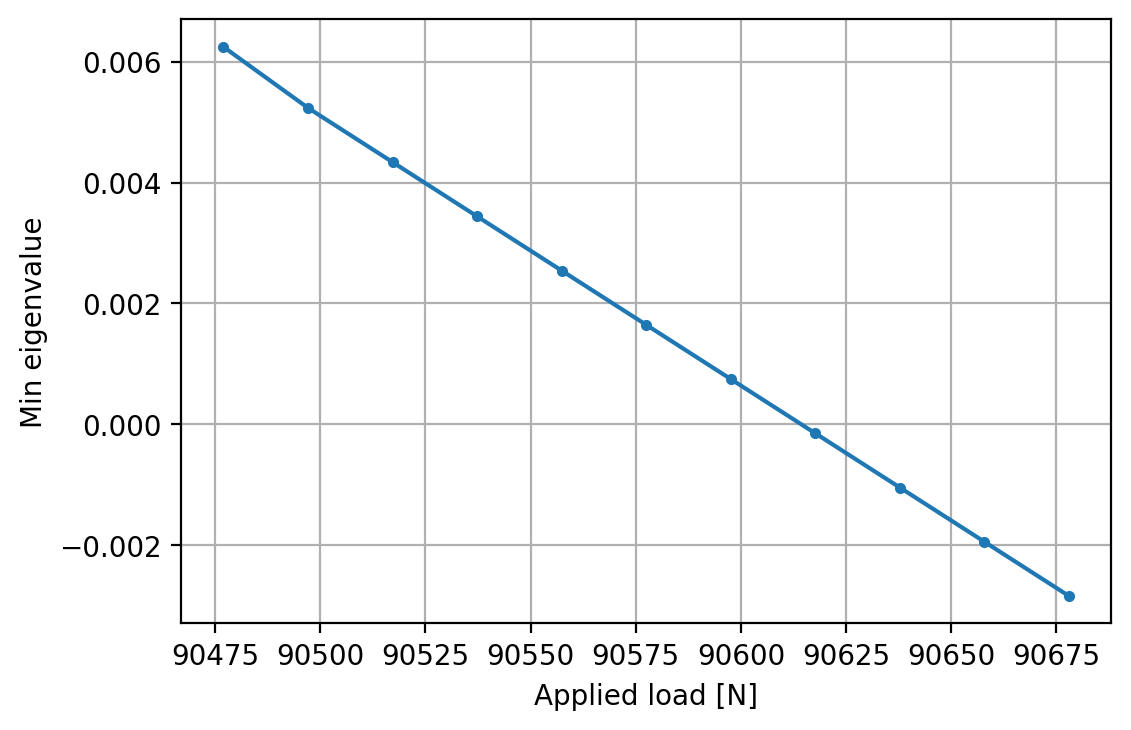

In [136]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.plot(force_magnitudes, min_eigenvalues, '.-')
plt.xlabel('Applied load [N]')
plt.ylabel('Min eigenvalue')
plt.grid()
plt.show()

The minimum eigenvalue crosses zero close to the buckling load predicted by the linear and the nonlinear analysis. To calculate the load where the tangent stiffness matrix becomes singular, we fit a line to the data and we find the load that corresponds to a null eigenvalue.

In [137]:
fit = np.polyfit(min_eigenvalues, force_magnitudes, 1)
line = np.poly1d(fit)
tangent_stiffness_matrix_buckling_load = line(0.)
print(f'Load where tangent stiffness matrix becomes singular: {tangent_stiffness_matrix_buckling_load:.0f} N')
print(f'Difference with respect to nonlinear buckling load: {(1-tangent_stiffness_matrix_buckling_load/sol_106_buckling_load)*100:.2f} %')

Load where tangent stiffness matrix becomes singular: 90614 N
Difference with respect to nonlinear buckling load: -0.04 %


There is a negligible difference with respect to the nonlinear buckling load calculated previously, that can be most probably ascribed to numerical approximations in the calculation of the eigenvalues.